# Introduction into PyNeuraLogic

Learning the XOR operation is a popular elementary task, and serves here as an example to showcase the basics of simple problem encoding and the library usage.

The XOR operation has two inputs - $X \in \{0, 1\}$ and $Y \in \{0, 1\}$, and one output $O \in \{0, 1\}$. The whole operation can be summarized by a table

| X | Y | O |
|---|---|---|
| 0 | 0 | 0 |
| 1 | 0 | 1 |
| 0 | 1 | 1 |
| 1 | 1 | 0 |

\* This classic tabular form of the learning problem suggests that it is merely *propositional* (~ single table) rather than [*relational*](https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-30164-8_719) (~ multible interlinked tables), which is the main aim of this library.
This will be reflected in the fact that we will not yet use *logical variables* in this example, causing the learning model to correspond to a standard feedforward network rather than a deep relational model, which is the core feature of this library.
Nevertheless, let us start simple for clarity here.

Install PyNeuraLogic from PyPI

In [1]:
! pip install neuralogic

     ---------------------------------------- 1.9/1.9 MB 30.2 MB/s eta 0:00:00


...and import some basic functionality

In [6]:
from neuralogic.nn import get_evaluator
from neuralogic.core import Backend, Relation, Template, Settings, Optimizer
from neuralogic.dataset import Dataset

## Template

We start by defining a learning model, generally called "template" in PyNeuraLogic. In this simple propositional example, you can think of these interchangeably.

The template for learning the XOR operation can be expressed in multiple ways; the following model reduces the architecture to one rule, representing one classic neural layer.

The rule can be read as: _"relation xor is implied by relation xy."_

\* the nullary "relation" with no arguments is commonly called a "proposition" or "fact" in logic.

In [4]:
template = Template()
template += Relation.xor[1, 8] <= Relation.xy[8, 2]

Note that we further specified the dimensionality of parameters associated with both the relations - $W_{xor}$ = [1,8] for relation "xor" and $W_{xy}$ = [8, 2] for relation "xy"
\(not to be confused with arguments of the relations, e.g. logical variables, which are not present here).

These parameters will translate into our (fully-connected) layers in the neural model, and will be initialized randomly from, by default, a uniform distribution (can be changed via Settings)

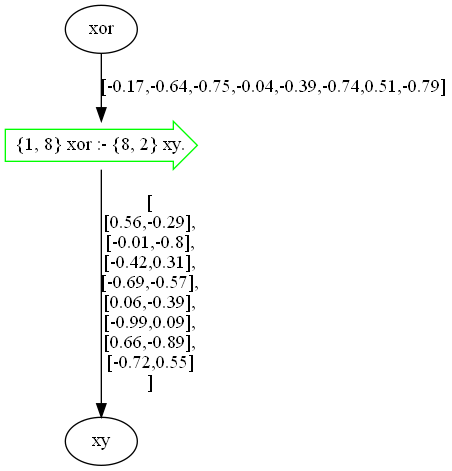

In [5]:
template.draw()

<!--- We also declared dimensionality of the weights for each part - $W_{xor}$ for relation "xor" and $W_{xy}$ for relation "xy".
-->

Let us take a closer look at what the template's rule represents here.
Once translated into a neural model, the xor rule corresponds to the following equation, where the output of $f(x)$ is the output of the "xor" relation and $x$ is the value of the "xy" relation.
Functions $\phi_{rule}$ and $\phi_{xor}$ are activation functions of our rule and the relation "xor", respectively.
By default, both $\phi_{rule}$ and $\phi_{xor}$ are equal to the $\tanh$ function.

$$W_{xor} \in \mathbb{R}^{1, 8}, W_{xy} \in \mathbb{R}^{8, 2}, x \in \{0,1\}^2$$

$$f(x) = \phi_{xor}(W_{xor} \cdot \phi_{rule}(W_{xy} \cdot x)) $$

Hence, this is a classic 2-layer fully-connected neural network, with a hidden layer of size 8 and a single output.


## Defining a Dataset

To be able to learn our parameters $W_{xor}$
and $W_{xy}$, we need to create a training dataset
that contains examples. In our case, the dataset
examples correspond directly to the rows of the XOR truth table.

In [3]:
dataset = Dataset()


dataset.add_examples(
    [
        Relation.xor[0] <= Relation.xy[[0, 0]],
        Relation.xor[1] <= Relation.xy[[0, 1]],
        Relation.xor[1] <= Relation.xy[[1, 0]],
        Relation.xor[0] <= Relation.xy[[1, 1]],
    ]
)

For example, the following example can be read as: _"Given the relation xy's value equal to the vector $(0, 1)$, we expect the relation xor to be equal to a scalar $1$."_

```
Relation.xor[1] <= Relation.xy[[0, 1]]
```

\*Note that while defining datasets, the numbers associated with each relation are interpreted as an actual value and not (a learnable) weight.

## Training

The training then does not differ much from classic deep learning frameworks, e.g. PyTorch.
We can do the training manually by writing a training loop, similarly to popular frameworks,  or using a predefined training loop implemented inside evaluators, which are suitable for quick prototyping and switching between different backends, such as DyNet or Java. Such evaluators can be conveniently customized via settings to specify optimizer, learning rate, error function, and more. In our example, we have chosen the Java backend with a stochastic gradient descent optimizer for training.

In [4]:
printouts = 10

settings = Settings(optimizer=Optimizer.SGD, epochs=100)
evaluator = get_evaluator(template, settings)
built_dataset = evaluator.build_dataset(dataset)

for epoch, (total_loss, seen_instances) in \
    enumerate(evaluator.train(built_dataset)):
    if epoch % printouts == 0:
        print(f"Epoch {epoch}, average loss {total_loss / seen_instances}")

Epoch 0, average loss 0.8486421179926945
Epoch 10, average loss 0.2523365313646398
Epoch 20, average loss 0.22581171403149267
Epoch 30, average loss 0.20155291380951051
Epoch 40, average loss 0.16632702588300935
Epoch 50, average loss 0.12272502214289742
Epoch 60, average loss 0.08378590695186636
Epoch 70, average loss 0.05659655622355965
Epoch 80, average loss 0.03952319346092247
Epoch 90, average loss 0.028906304842870375


Before the training is evaluated, our dataset is "grounded" with our template. The grounding then yields one computation graph for each query from the dataset. In this propositional problem setting, this will produce, for each query, a computation network with the same structure but with different input and target values.

## Testing
Evaluators also encapsulate testing with a user-friendly interface that is analogous to training.

In [5]:
for label, predicted in evaluator.test(built_dataset):
    print(f"Label: {label}, predicted: {predicted}")


Label: 0, predicted: 0
Label: 1, predicted: 0.7998393002473414
Label: 1, predicted: 0.7991515636502554
Label: 0, predicted: 0.0324124386538237
